## KMeans Class Implementation

This section defines the KMeans clustering algorithm class.

>  A centroid is the imaginary center point of a cluster. It's essentially the average position of all data points assigned to that specific cluster.

In [9]:
import numpy as np
from collections import Counter
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

In [10]:
class KMeans:
    """
    Implementation of K-means algorithm based on Forgy's method
    """
    def __init__(self, k=3, max_iters=100, random_state=None):
        self.k = k
        self.max_iters = max_iters
        self.random_state = random_state

    def _initialize_centroids(self, X):
        if self.random_state:
            np.random.seed(self.random_state)
        n_samples, n_features = X.shape
        centroids = np.zeros((self.k, n_features))
        for i in range(self.k):
            centroids[i] = X[np.random.choice(n_samples)]
        return centroids

    def _assign_clusters(self, X, centroids):
        distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
        return np.argmin(distances, axis=0)

    def _update_centroids(self, X, labels):
        centroids = np.zeros((self.k, X.shape[1]))
        for i in range(self.k):
            if np.sum(labels == i) > 0:
                centroids[i] = X[labels == i].mean(axis=0)
            else:
                centroids[i] = X[np.random.choice(X.shape[0])]
        return centroids

    def _calculate_wcss(self, X, labels, centroids):
        wcss = 0
        for i in range(self.k):
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                wcss += np.sum((cluster_points - centroids[i])**2)
        return wcss

    def _calculate_bcss(self, X, labels, centroids):
        overall_mean = np.mean(X, axis=0)
        bcss = 0
        for i in range(self.k):
            n_i = np.sum(labels == i)
            if n_i > 0:
                bcss += n_i * np.sum((centroids[i] - overall_mean)**2)
        return bcss

    def fit(self, X):
        self.centroids = self._initialize_centroids(X)
        for _ in range(self.max_iters):
            labels = self._assign_clusters(X, self.centroids)
            new_centroids = self._update_centroids(X, labels)
            if np.allclose(self.centroids, new_centroids):
                break
            self.centroids = new_centroids
        self.labels_ = labels
        
        self.wcss_ = self._calculate_wcss(X, labels, self.centroids) 
        # Within-Cluster Sum of Squares, is a metric used in K-Means clustering to evaluate the compactness of clusters
        self.bcss_ = self._calculate_bcss(X, labels, self.centroids)
        # Between-Cluster Sum of Squares, is a metric used in K-Means clustering to evaluate the separation between clusters
        return self

    def predict(self, X):
        return self._assign_clusters(X, self.centroids)

## Load and Preprocess the Wine Dataset
This section loads the wine dataset and standardizes the features for clustering.

In [11]:
# Load wine dataset
print("Loading wine dataset...")
X, y = load_wine(return_X_y=True)
print(f"Dataset shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")

# Standardize the data (important for k-means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Loading wine dataset...
Dataset shape: (178, 13)
Number of features: 13
Number of samples: 178


## Run K-means Multiple Times
This section runs the K-means algorithm 30 times to analyze partition stability and performance.

In [12]:
def partition_to_string(labels):
    """Convert partition labels to a string, relabeling clusters by descending size for significance."""
    label_counts = Counter(labels)
    # Sort labels by cluster size (descending), then by label value for tie-breaking
    sorted_labels = [label for label, _ in sorted(label_counts.items(), key=lambda x: (-x[1], x[0]))]
    label_map = {old_label: new_label for new_label, old_label in enumerate(sorted_labels)}
    normalized_labels = np.array([label_map[label] for label in labels])
    return ''.join(map(str, normalized_labels))

# Run k-means 30 times
print("\nRunning k-means algorithm 30 times...")
results = []
partitions = []
for i in range(30):
    kmeans = KMeans(k=3, max_iters=100, random_state=i)
    kmeans.fit(X_scaled)
    results.append({
        'run': i+1,
        'labels': kmeans.labels_.copy(),
        'centroids': kmeans.centroids.copy(),
        'wcss': kmeans.wcss_,
        'bcss': kmeans.bcss_,
        'partition_str': partition_to_string(kmeans.labels_)
    })
    partitions.append(partition_to_string(kmeans.labels_))


Running k-means algorithm 30 times...


## Analyze Partition Frequencies and Statistics
This section counts unique partitions, their frequencies, and computes W(P) and B(P) for each partition type.

In [13]:
# Count partition frequencies
partition_counts = Counter(partitions)
print(f"\nNumber of unique partitions found: {len(partition_counts)}")
print("\nPartition frequencies:")
for i, (partition, count) in enumerate(partition_counts.most_common()):
    print(f"Partition {i+1}: {count} times")

# Report W(P) and B(P) for each unique partition
print("\nW(P) and B(P) values for each partition type:")
partition_stats = {}
for result in results:
    partition_str = result['partition_str']
    if partition_str not in partition_stats:
        partition_stats[partition_str] = {
            'wcss_values': [],
            'bcss_values': [],
            'count': 0
        }
    partition_stats[partition_str]['wcss_values'].append(result['wcss'])
    partition_stats[partition_str]['bcss_values'].append(result['bcss'])
    partition_stats[partition_str]['count'] += 1
for i, (partition_str, stats) in enumerate(partition_stats.items()):
    avg_wcss = np.mean(stats['wcss_values'])
    avg_bcss = np.mean(stats['bcss_values'])
    print(f"Partition {i+1} (appeared {stats['count']} times):")
    print(f"  Average W(P): {avg_wcss:.4f}")
    print(f"  Average B(P): {avg_bcss:.4f}")


Number of unique partitions found: 7

Partition frequencies:
Partition 1: 8 times
Partition 2: 6 times
Partition 3: 6 times
Partition 4: 4 times
Partition 5: 3 times
Partition 6: 2 times
Partition 7: 1 times

W(P) and B(P) values for each partition type:
Partition 1 (appeared 8 times):
  Average W(P): 1277.9285
  Average B(P): 1036.0715
Partition 2 (appeared 4 times):
  Average W(P): 1279.7311
  Average B(P): 1034.2689
Partition 3 (appeared 6 times):
  Average W(P): 1282.4635
  Average B(P): 1031.5365
Partition 4 (appeared 3 times):
  Average W(P): 1278.7608
  Average B(P): 1035.2392
Partition 5 (appeared 2 times):
  Average W(P): 1575.3202
  Average B(P): 738.6798
Partition 6 (appeared 6 times):
  Average W(P): 1279.9662
  Average B(P): 1034.0338
Partition 7 (appeared 1 times):
  Average W(P): 1588.2028
  Average B(P): 725.7972


## Select Best Partition and Visualize with PCA
This section finds the best clustering result and visualizes it in 3D using PCA.


Best partition (minimum W(P)):
Run number: 1
W(P): 1277.9285
B(P): 1036.0715

Applying PCA for 3D visualization...
Explained variance ratio: [0.36198848 0.1920749  0.11123631]
Total explained variance: 0.6653


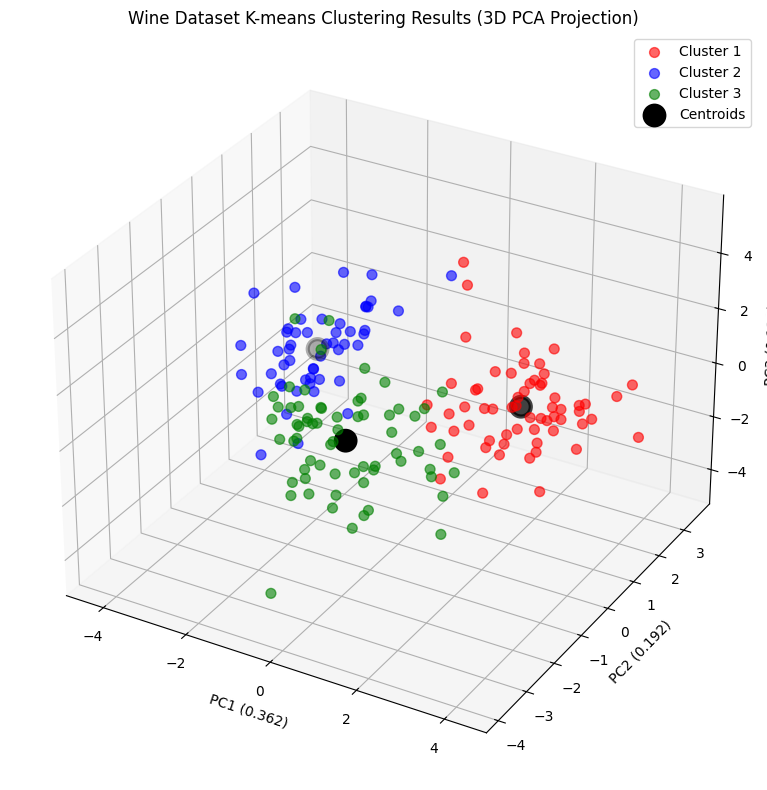

In [14]:
# Find the result with minimum W(P)
best_result = min(results, key=lambda x: x['wcss'])
print(f"\nBest partition (minimum W(P)):")
print(f"Run number: {best_result['run']}")
print(f"W(P): {best_result['wcss']:.4f}")
print(f"B(P): {best_result['bcss']:.4f}")

# Use PCA for 3D visualization
print("\nApplying PCA for 3D visualization...")
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)
# Transform centroids to PCA space
centroids_pca = pca.transform(best_result['centroids'])
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.4f}")
# Create 3D visualization
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['red', 'blue', 'green']
cluster_names = ['Cluster 1', 'Cluster 2', 'Cluster 3']
for i in range(3):
    mask = best_result['labels'] == i
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], X_pca[mask, 2],
              c=colors[i], label=cluster_names[i], alpha=0.6, s=50)
ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1], centroids_pca[:, 2],
          c='black', s=200, linewidths=3, label='Centroids')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f})')
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.3f})')
ax.set_title('Wine Dataset K-means Clustering Results (3D PCA Projection)')
ax.legend()
plt.tight_layout()
plt.show()